This notebook aims to instill the flexibility of MCGLM alongside its comprehensive list of viable analyses.

In [1]:
import sys, os

import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mcglm import MCGLM, mc_mixed, mc_id, mc_ma
from patsy import dmatrix
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_process import ArmaProcess

import warnings

warnings.simplefilter("ignore")

MCGLM is a one-stop for statistical analysis.   

The statistical framework Multivariate Covariance Generalized Linear Model (MCGLM) provides a unified model for adjusting a wide variety of data such as gaussian or non-gaussian, univariate or multivariate, dependent or independent. This pliability comes from the second-moment assumptions and the straightforward yet thorough specification of pivotal model components. The model relies on the specification of five components: linear predictor/design matrix, link function, variance function, covariance function, and dependencies matrices Z. To instill seamlessly in the model, let's get started with a short review of some milestones of statistical models over the last 2 centuries.


The statistical model `Linear Regression` is dated to the early nineteenth century. Legendre and Gauss played an essential role in the postulation of this model. According to (McCullagh, P and Nelder, J.A, 1989) in their fantastic book "Generalized Linear Models", yet rephrased by myself, an enthusiast disciple, Linear Regression can be dissected into two components: The Systematic and Random parts.


Assuming an outcome variable $\boldsymbol{y}$ with $n$ components considered independent realizations of a random variable $\boldsymbol{Y}$. There is a vector $\boldsymbol{\mu}$ which holds the mean parameters of those realizations. The systematic part of the model specifies the vector $\boldsymbol{\mu}$ by employing a linear operation between regression parameters $\beta_1,...,\beta_p$ and the covariates. The mathematical notation for the systematic part:  
 
  \begin{equation*}
    \mathrm{E}(Y_i) =  
    \mathrm{\mu_i} = 
    \beta_0 + 
    \sum_{j=1}^{p} x_{ij}\beta_j;\qquad i = 1,...,n.
    %\mathrm{V}(\boldsymbol{\mu}_r;p_r)^{\frac{1}{2}} (\boldsymbol{\Omega}(\boldsymbol{\tau}_r))
    %\mathrm{V}(\boldsymbol{\mu}_r;p_r)^{\frac{1}{2}}.
  \end{equation*}

where $x_{ij}$ is the value of the jth covariate for observation $i$.

Moreover, as the random part, we assume independence and constant variance of errors. These errors follow a Gaussian distribution with mean 0 and constant variance $\sigma^2$. It sets to the Linear Regression the known adjective `Homoscedasticity`.

For a simple Linear Regression, with the first regression parameter, the $\beta_0$, set as 0, the model graphically shapes as the image below:

![title](linear_regression.png)

-------------

In 1972, Nelder and Wedderburn went a step further in unifying the theory of statistical modeling and, in particular, regression models, publishing their article on generalized linear models (GLM). 

In the context of GLM, each component of the random variable $Y$ assumes a distribution in the `exponential family`, in which the density function takes the form.

\begin{equation*}
    \mathrm{f}_y(y;\theta,\phi) = 
    \mathrm{exp\{(y\theta - b(\theta))/a(\phi) + c(y,\phi)\}}
\end{equation*}


for some specific functions $a(\phi)$, $b(\theta)$ and $c(y,\phi)$. Mean and Variance can be specified as:   
  
\begin{equation*}
    \mathrm{E}(Y) = b'(\theta).\qquad
    \mathrm{Var}(Y) = b''(\theta)a(\phi). 
\end{equation*}

A couple of possible models in this framework:

\begin{array}{lll} \hline
    \text{Distribution}  & \text{Support} & \text{Cases} \\ \hline
    \text{Gaussian}  & \text{Real Numbers} & \text{General Symmetric Distributions.} \\
    \text{Binomial(Bernoulli)}  & \text{Bounded Data} & \text{Probability/Odds of an event.} \\
    \text{Poisson}  & \text{Integer Positive} & \text{Positive Count Distributions.} \\ 
    \text{Gamma}  & \text{Real Positive Numbers} & \text{Positive Asymmetric Distributions.} \\ 
    \text{Inverse Gaussian} & \text{Real Positive Numbers} & \text{Positive Asymmetric Distributions.} \\ \hline
\end{array}



GLM relies on three components: A design matrix with covariates; A Link Function that transforms the $\boldsymbol{\eta}$, the result of a linear operation between covariates and regression parameters, into $\boldsymbol{\mu}$; A exponential distribution model or a Variance function. The usual choices for the link and variance functions.


\begin{array}{lll} \hline
    \text{Distribution}  & \text{Canonical link function} & \text{Variance function} \\ \hline
    \text{Poisson}     & \text{Log} & \text{$\mu$} \\
    \text{Binomial}    & \text{Logit} & \text{$\mu(\mu - 1)$} \\
    \text{Normal}  & \text{Identity} & \text{1} \\ 
    \text{Gamma}  & \text{Reciprocal} & \text{$\mu^2$} \\ 
    \text{Inverse Gaussian}  & \text{Reciprocal²} & \text{$\mu^3$} \\ \hline
\end{array}


The `maximum-likelihood` estimator leverages the underlying distribution to find regression and dispersion parameters that maximize the product of likelihood. Therefore, the two assumptions of GLM are: Linearity upon the link function; The random variable $Y$ is independently distributed as some exponential family distribution. As follows, two simple linear estimating Poisson and Binomial models. 

![title](regressao_binomial.png)

--
![title](regressao_poisson.png)

-------------

Wedderburn, one of the authors of GLM, published 1974 one of the most iconic papers of history. "Quasi-Likelihood Functions, Generalized Linear Models, and the Gauss-Newton Method". He proposed a near likelihood estimator, the `quasi-likelihood`, which does not rely on a distribution model, yet asymptotically the convergence is guaranteed. As long as statisticians cannot know the distribution upfront, the `quasi-likelihood` play an essential role in statistical models. The `quasi-score` is an Estimating Equation for Quasi-likelihood functions. 

-----------------------------

In 1986, Liang and Zeger published the paper "Longitudinal data analysis using generalized linear models", which establishes an extension of Generalized Linear Models (GLM) to longitudinal data analysis. The paper epitomizes that data scenario.

```
The severity of respiratory disease, along with the nutritional status, age, and family income of children, might be observed once every three months for 18 months. The dependence of the outcome variable, severity of disease, on the covariates is of interest.
```

The paper introduces estimating equations that give consistent estimates of the regression parameters and of their variances under weak assumptions about the joint distribution, the model GEE. The dispersion parameters remain a nuisance. The model harnesses the correlation matrix to define the dependence between components of the response variable. Furthermore, the paper suggests some depedences structures for GEE: `independent`, `autoregressive`, `exchangeable`, `unstructured`, `stationary-M`, `M-dependent` or `non-stationary`. The GEE relies on the specification of four components: Design Matrix with covariates; Link function; Variance function; Correlation Matrix.

---------------------------

Finally, in 2015, Bonat and Jørgensen published the MCGLM, A brand new family of Statistical Models: Multivariate Covariance Generalized Linear Models. This model can fit many kinds of dependence, such as longitudinal and spatial dependence. This dependence is specified by means of dependence matrices and covariance link functions. Moreover, the model can fit multi-responses at once. The MCGLM, on the two-moment specification, is described as:  


 Let $X_r$ denote an $N$ x $k_r$ a design matrix and $\beta_r$ a $k_r$ x 1 regression parameter vector for the response $r$. The mean and variance for MCGLM are: 

  \begin{equation*}
    \mathrm{E}(\mathbf{Y}) = \mathbf{M} = \{g_1^{-1}(\boldsymbol{X}_1 \boldsymbol{\beta}_1), \ldots, g_R^{-1}(\boldsymbol{X}_R \boldsymbol{\beta}_R)\},  
  \end{equation*}
  
  \begin{equation*}
    \mathrm{Var}(\mathbf{Y}) = \boldsymbol{C} = \boldsymbol{\Sigma}_R \overset{G} \otimes \boldsymbol{\Sigma}_b. 
  \end{equation*}
  

  The component $C$ is calculated by means of generalized product Kronecker $\boldsymbol{\Sigma}_R \overset{G} \otimes \boldsymbol{\Sigma}_b = 
  \mathrm{Bdiag}(\tilde{\boldsymbol{\Sigma}}_1, \ldots, 
  \tilde{\boldsymbol{\Sigma}}_R)(\boldsymbol{\Sigma}_b \otimes 
  \boldsymbol{I})\mathrm{Bdiag}(\tilde{\boldsymbol{\Sigma}}_1^T, \ldots, 
  \tilde{\boldsymbol{\Sigma}}_R^T)$. The matrix $\tilde{\boldsymbol{\Sigma}}_r$ denotes a lower triangular matrix, resulting of a Cholesky decomposition from $\boldsymbol{\Sigma}_r$. The operator $\mathrm{Bdiag}$ itemize a block diagonal matriz e $\boldsymbol{I}$ denotes $N \times N$ an identity matrix.
  
The matrix $\boldsymbol{\Sigma}_r$, a.k.a covariance matrix of the outcome r, is defined by: 

  \begin{equation*}
  \boldsymbol{\Sigma}_r = 
  \mathrm{V}(\boldsymbol{\mu}_r;p_r)^{\frac{1}{2}} (\boldsymbol{\Omega}(\boldsymbol{\tau}_r))
  \mathrm{V}(\boldsymbol{\mu}_r;p_r)^{\frac{1}{2}}.
  \end{equation*}

Where $\mathrm{V}(\boldsymbol{\mu}_r;p_r) = \mathrm{diag}(\vartheta(\boldsymbol{\mu}_r;p_r))$ is a diagonal matrix, whose entries are defined by means of variance functions. Each function distinguishes marginal distribution. The operation omega $\boldsymbol{\Omega}(\boldsymbol{\tau}_r)$, the matrix linear matricial, describes the covariance inhrently to the mean structure. 

\begin{equation*}
  \boldsymbol{\Omega}(\boldsymbol{\tau}_r) = h_r^{-1}(\tau_{r0} Z_{r0} + \cdots + \tau_{rD} Z_{rD}).
\end{equation*}
    
Where $\mathrm{h}$ is a covariance link function specified. The matrices Z specifies the data dependencies. Finally, $\Sigma_b$ the $R$ x $R$ correlation matrix between outcomes, calculated by the Pearson estimator. Therefore, MCGLM rely on specification of five components: Design matrix with covariates; Link function; Variance function; Z matrices for the dependence specification; Covariance link function.

Please check out the original article of MCGLM for deeper details regarding the optimization method, goodness-of-fit measurements, and estimates properties.

------------------------
The brand new library `mcglm`.

The Python library `mcglm` provides an easy interface for fitting the MCGLM model, similar to the library statsmodels, providing auxiliary methods to lead a proper specification of each MCGLM component. The library provides a comprehensive report for the model fitting analysis with regression parameters, dispersion parameters, confidence intervals, hypothesis testing, and Pearson residue. As yet, only users of R users have access to the MCGLM algorithm by the package mcglm. 

Finally, this notebook presents some statistical analysis with the support of Python mcglm.

Refs: 

https://www.jstor.org/stable/44681850    
https://www.researchgate.net/publication/324579147_Multiple_Response_Variables_Regression_Models_in_R_The_mcglm_Package    

This new implementation is available on PyPI and can be installed with `pip` tool.

https://pypi.org/project/mcglm/  

In [2]:
print(MCGLM.__doc__)


    MCGLM class that implements MCGLM stastical models. (Bonat, Jørgensen 2015)
        
    It extends GLM for multi-responses and dependent components by fitting second-moment assumptions.

    Parameters
    ----------
    endog : array_like
        1d array of endogenous response variable. In case of multiple responses, the user must pass the responses on a list.  
    exog : array_like
        A dataset with the endogenous matrix in a Numpy fashion. Since the library doesn't set an intercept by default, the user must add it. In the case of multiple responses, the user must pass the design matrices as a python list. 
    z : array_like
        List with matrices components of the linear covariance matrix.
    link : array_like, string or None
        Specification for the link function. The MCGLM library implements the following options: identity, logit, power, log, probit, cauchy, cloglog, loglog, negativebinomial. In the case of None, the library chooses the identity link. In mu

The MCGLM framework behaves conditioned by the link and variance function, as this doc aims to demonstrate some of them. Let's get started with the first one: the homoscedasticity least squares linear regression.

#### Linear Regression   

-------------

Perhaps the most popular statistical model, Linear Regression is a great choice when data meets the three assumptions:   

1. Linearity.   
2. Independence of components Y. a.k.a iid.   
3. The distribution of error following a Gaussian with tuple (0, dispersion).    



A statistical analysis on the classical Boston dataset.

In [3]:
from sklearn.datasets import load_boston

X, y = load_boston(return_X_y=True)
X = pd.DataFrame(X)
y = pd.Series(y, name="output")

Text(0.5, 1.0, 'Histogram of Boston Dataset')

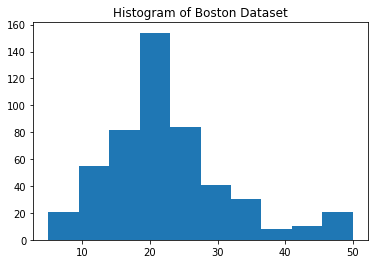

In [4]:
_ = plt.hist(y)
plt.title("Histogram of Boston Dataset")

MCGLM can adjust a similar ordinary linear regression as long as link and variance functions are settled with `identity` and `constant`, on top of independent components of $Y$.   

In [5]:
modelresults = MCGLM(endog=y, exog=X, z=[mc_id(X)]).fit()
modelresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:                 output   No. Iterations:                      1
Model:                          MCGLM   No. Observations:                  506
link:                        identity   Df Residuals:                      492
variance:                    constant   Df Model:                           14
Method:              Quasi-Likelihood   Power-fixed:                      True
Date:                Sun, 27 Nov 2022   pAIC                           2569.55
Time:                        19:03:04   pBIC                           2628.73
                                        pLogLik                     -1270.7774
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0929      0.034     -2.734      0.006      -0.159      -0.026
1              0.0487      0.014      3.427      0.001       0.021       0.077
2             -0.0041      0.064     -0.064      0.949      -0.129       0.121
3              2.8540      0.892      3.199      0.001       1.105       4.603
4             -2.8684      3.315     -0.865      0.387      -9.366       3.629
5              5.9281      0.305     19.429      0.000       5.330       6.526
6             -0.0073      0.014     -0.533      0.594      -0.034       0.019
7             -0.9685      0.193     -5.016      0.000      -1.347      -0.590
8              0.1712      0.066      2.598      0.009       0.042       0.300
9             -0.0094      0.004     -2.426      0.015      -0.017      -0.002
10            -0.3922      0.108     -3.616      0.000      -0.605      -0.180
11             0.0149      0.003      5.600      0.000       0.010       0.020
12            -0.4163      0.050     -8.305      0.000      -0.515      -0.318
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1    24.1660      3.308      7.305      0.000      17.682      30.650
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         1.0000        nan        nan        nan         nan         nan
==============================================================================
"""

The residual analysis is key for assessing the fulfillment of the assumptions. For more details, check out (Montgomery. D.C and Runger. G.C, 2013)

Text(0, 0.5, 'pearson residuals')

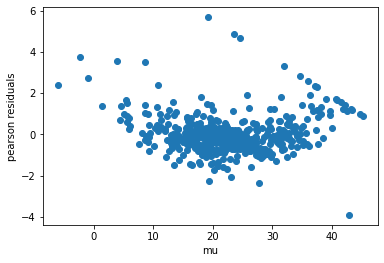

In [6]:
# Residual Analysis
plt.scatter(modelresults.mu, modelresults.pearson_residuals)
plt.xlabel("mu")
plt.ylabel("pearson residuals")

##### A Count Model  

-------------
This dataset has information from a Canadian study of mortality by age and smoking status.  https://data.princeton.edu/wws509/datasets/#smoking. The four-column dataset establishes features: `age`, `smoking status`, `population`, and the outcome `deaths`.  

In [17]:
smoking_data = pd.read_csv("data/smoking_data.csv")

## exog and endog
X = dmatrix("~ pop + age + smoke", smoking_data, return_type="dataframe")
y = smoking_data["dead"]

Text(0.5, 1.0, 'Histogram of absolute count of deads')

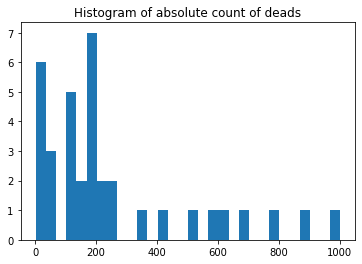

In [18]:
_ = plt.hist(y, bins=30)
plt.title("Histogram of absolute count of deads")

That is a long-tail distribution.   

Straight off the bat, we adjust by means of link and variance as `identity` and `constant`.  

In [19]:
modelresults = MCGLM(
    y,
    X,
    [mc_id(X)],
).fit()

modelresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:                   dead   No. Iterations:                      1
Model:                          MCGLM   No. Observations:                   36
link:                        identity   Df Residuals:                       22
variance:                    constant   Df Model:                           14
Method:              Quasi-Likelihood   Power-fixed:                      True
Date:                Sun, 27 Nov 2022   pAIC                            429.44
Time:                        19:16:18   pBIC                            451.61
                                        pLogLik                       -200.719
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  -224.6373     66.931     -3.356      0.001    -355.820     -93.455
age[T.45-59]                 95.3834     76.446      1.248      0.212     -54.448     245.215
age[T.50-54]                147.8634     78.491      1.884      0.060      -5.977     301.703
age[T.55-59]                216.4651     74.395      2.910      0.004      70.654     362.276
age[T.60-64]                344.0038     76.451      4.500      0.000     194.162     493.846
age[T.65-69]                426.7793     74.466      5.731      0.000     280.829     572.730
age[T.70-74]                399.1722     78.027      5.116      0.000     246.242     552.103
age[T.75-79]                335.9303     83.318      4.032      0.000     172.629     499.231
age[T.80+]                  293.7420     86.312      3.403      0.001     124.573     462.911
smoke[T.2.cigarPipeOnly]     32.3389     49.616      0.652      0.515     -64.906     129.584
smoke[T.3.cigarrettePlus]    85.2001     76.811      1.109      0.267     -65.347     235.747
smoke[T.4.cigarretteOnly]    87.8965     60.879      1.444      0.149     -31.425     207.218
pop                           0.1128      0.023      4.814      0.000       0.067       0.159
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1  1.107e+04   1899.730      5.825      0.000    7342.638    1.48e+04
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         1.0000        nan        nan        nan         nan         nan
==============================================================================
"""

Let's try a `tweedie adjustment` with power set as one, as a Poisson one.

In [20]:
modelresults = MCGLM(
    y,
    X,
    [mc_id(X)],
    link="log",
    variance="tweedie",
    power=1,
    power_fixed=True,
).fit()

modelresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:                   dead   No. Iterations:                      1
Model:                          MCGLM   No. Observations:                   36
link:                             log   Df Residuals:                       22
variance:                     tweedie   Df Model:                           14
Method:              Quasi-Likelihood   Power-fixed:                      True
Date:                Sun, 27 Nov 2022   pAIC                            371.22
Time:                        19:16:30   pBIC                            393.39
                                        pLogLik                      -171.6087
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     2.5604      0.283      9.056      0.000       2.006       3.115
age[T.45-59]                  0.6242      0.310      2.011      0.044       0.016       1.233
age[T.50-54]                  1.0038      0.308      3.261      0.001       0.401       1.607
age[T.55-59]                  1.3818      0.245      5.635      0.000       0.901       1.862
age[T.60-64]                  1.5012      0.245      6.133      0.000       1.021       1.981
age[T.65-69]                  2.1366      0.240      8.920      0.000       1.667       2.606
age[T.70-74]                  2.3557      0.269      8.766      0.000       1.829       2.882
age[T.75-79]                  2.2041      0.298      7.403      0.000       1.621       2.788
age[T.80+]                    1.9506      0.318      6.143      0.000       1.328       2.573
smoke[T.2.cigarPipeOnly]      0.2114      0.176      1.203      0.229      -0.133       0.556
smoke[T.3.cigarrettePlus]     0.5030      0.214      2.347      0.019       0.083       0.923
smoke[T.4.cigarretteOnly]     0.7818      0.164      4.755      0.000       0.460       1.104
pop                           0.0004   6.25e-05      6.679      0.000       0.000       0.001
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1    14.1200      3.786      3.729      0.000       6.699      21.541
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         1.0000        nan        nan        nan         nan         nan
==============================================================================
"""

Text(0, 0.5, 'pearson residuals')

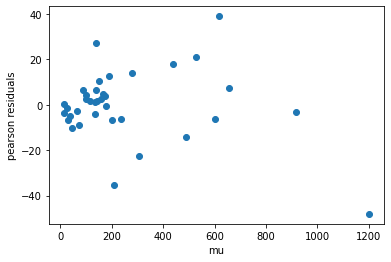

In [21]:
# Residual Analysis
plt.scatter(modelresults.mu, modelresults.pearson_residuals)
plt.xlabel("mu")
plt.ylabel("pearson residuals")

By the `pAIC` metric, the usual `Tweedie` variance function is a suitable pick.


------

It is plain to harness an important trait of `mcglm` library, the power estimation for `Tweedie`. We have got to set the parameter power_fixed as `False`. 

In [24]:
modelresults = MCGLM(
    y,
    X,
    [mc_id(X)],
    link="log",
    variance="tweedie",
    power=1,
    power_fixed=False,
).fit()

modelresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:                   dead   No. Iterations:                     12
Model:                          MCGLM   No. Observations:                   36
link:                             log   Df Residuals:                       22
variance:                     tweedie   Df Model:                           14
Method:              Quasi-Likelihood   Power-fixed:                     False
Date:                Sun, 27 Nov 2022   pAIC                            370.19
Time:                        19:17:46   pBIC                            392.36
                                        pLogLik                      -171.0955
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     2.4484      0.269      9.089      0.000       1.920       2.976
age[T.45-59]                  0.6564      0.298      2.202      0.028       0.072       1.241
age[T.50-54]                  1.0409      0.298      3.489      0.000       0.456       1.626
age[T.55-59]                  1.3908      0.244      5.702      0.000       0.913       1.869
age[T.60-64]                  1.5248      0.242      6.290      0.000       1.050       2.000
age[T.65-69]                  2.1931      0.236      9.276      0.000       1.730       2.656
age[T.70-74]                  2.4557      0.263      9.336      0.000       1.940       2.971
age[T.75-79]                  2.3393      0.290      8.065      0.000       1.771       2.908
age[T.80+]                    2.1147      0.307      6.887      0.000       1.513       2.717
smoke[T.2.cigarPipeOnly]      0.1688      0.172      0.980      0.327      -0.169       0.506
smoke[T.3.cigarrettePlus]     0.4441      0.217      2.045      0.041       0.018       0.870
smoke[T.4.cigarretteOnly]     0.7363      0.167      4.406      0.000       0.409       1.064
pop                           0.0005   6.41e-05      7.091      0.000       0.000       0.001
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1     3.7750      3.430      1.101      0.271      -2.947      10.497
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         1.2630      0.179      7.063      0.000       0.913       1.613
==============================================================================
"""

By the `pAIC`, the adjustment with power set 1.263 is lightly better than 1. It points out that the distribution `Compound Poisson/Gamma` is the best option for this data learning.

##### Bounded data
-------------

For a bound analysis, let's leverage the iconic titanic dataset.

In [124]:
titanic = pd.read_csv("data/titanic.csv")

In [125]:
y = titanic["Survived"]

X = titanic[["Fare", "SibSp", "Embarked", "Parch", "Pclass"]]
X = X.fillna("S")

X = dmatrix("~ Fare + SibSp + Embarked + Parch + Pclass", X, return_type="dataframe")

In [126]:
modelresults = MCGLM(
    y,
    X,
    [mc_id(X)],
    link="logit",
    variance="binomialP",
    ntrial=1,
).fit()
modelresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:               Survived   No. Iterations:                      0
Model:                          MCGLM   No. Observations:                  891
link:                           logit   Df Residuals:                      883
variance:                   binomialP   Df Model:                            8
Method:              Quasi-Likelihood   Power-fixed:                      True
Date:                Fri, 28 Oct 2022   pAIC                             213.8
Time:                        07:41:47   pBIC                            252.14
                                        pLogLik                       -98.9013
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.4120      0.343      4.119      0.000       0.740       2.084
Embarked[T.Q]     0.2911      0.307      0.948      0.343      -0.311       0.893
Embarked[T.S]    -0.5179      0.197     -2.635      0.008      -0.903      -0.133
Fare              0.0037      0.002      1.553      0.120      -0.001       0.008
SibSp            -0.1274      0.082     -1.560      0.119      -0.288       0.033
Parch             0.2920      0.101      2.904      0.004       0.095       0.489
Pclass           -0.7556      0.116     -6.503      0.000      -0.983      -0.528
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1     0.9990      0.036     27.996      0.000       0.929       1.069
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         1.0000        nan        nan        nan         nan         nan
==============================================================================
"""

For a bounded scenario, we have four different link functions on the mcglm library.

In [50]:
## Evaluating multiple links
modelresults_logit = MCGLM(
    y, X, [mc_id(X)], link="logit", variance="binomialP", ntrial=1
).fit()

modelresults_loglog = MCGLM(
    y, X, [mc_id(X)], link="loglog", variance="binomialP", ntrial=1
).fit()

modelresults_cloglog = MCGLM(
    y, X, [mc_id(X)], link="cloglog", variance="binomialP", ntrial=1
).fit()

modelresults_cauchy = MCGLM(
    y, X, [mc_id(X)], link="cauchy", variance="binomialP", ntrial=1
).fit()

In [51]:
print(
    "logit_aic: ",
    modelresults_logit.aic,
    ", loglog_aic: ",
    modelresults_loglog.aic,
    ", cloglog_aic: ",
    modelresults_cloglog.aic,
    ", cauchy_aic: ",
    modelresults_cauchy.aic,
)

logit_aic:  213.8 , loglog_aic:  200.75 , cloglog_aic:  223.56 , cauchy_aic:  218.02


The loglog link is the best pick for this analysis.

In addition to it, the `mcglm` can fit data when components are not independent.

------------------

### Dependence section

Moving Average model. 

The library `statmodels` has an amazing API to craft Arma process. Let's use it to generate data, and then adjust a model.

In [27]:
arma_obj = ArmaProcess(ar=[1], ma=[1, 2])
arma_sample = arma_obj.generate_sample(nsample=300)

data = pd.DataFrame()
data["arma_sample"] = arma_sample
data["index"] = list(range(0, 300))
data = add_constant(data)

X = data[["const"]]
y = data["arma_sample"]

<AxesSubplot:xlabel='index', ylabel='arma_sample'>

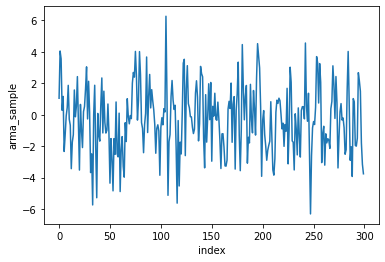

In [28]:
sns.lineplot(data["index"], data["arma_sample"])

By default, time-series analysis starts with the usual decomposition on trend, seasonal and residual(shock). In this analysis, as long as we have crafted from ARMA process, we can adjust a model MA straight off the bat.

The measure of goodness-of-fit `pAIC` is crucial to point the best pick.

In [29]:
one_order = [mc_id(X), mc_ma(id="const", time="index", data=data, order=1)]
two_order = [*one_order, mc_ma(id="const", time="index", data=data, order=2)]
three_order = [*two_order, mc_ma(id="const", time="index", data=data, order=3)]
four_order = [*three_order, mc_ma(id="const", time="index", data=data, order=4)]
five_order = [*four_order, mc_ma(id="const", time="index", data=data, order=5)]
six_order = [*five_order, mc_ma(id="const", time="index", data=data, order=6)]
seven_order = [*six_order, mc_ma(id="const", time="index", data=data, order=7)]

In [30]:
for index, order in enumerate(
    [one_order, two_order, three_order, four_order, five_order, six_order, seven_order]
):
    modelresults = MCGLM(y, X, order).fit()

    print("q value: ", str(index + 1), ", paic: ", modelresults.aic)

q value:  1 , paic:  963.79
q value:  2 , paic:  965.7
q value:  3 , paic:  966.51
q value:  4 , paic:  968.51
q value:  5 , paic:  970.36
q value:  6 , paic:  972.35
q value:  7 , paic:  973.41


Lag size q as 1 as the best fit.

In [117]:
modelresults = MCGLM(y, X, one_order).fit()
modelresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:            arma_sample   No. Iterations:                     10
Model:                          MCGLM   No. Observations:                  300
link:                        identity   Df Residuals:                      297
variance:                    constant   Df Model:                            3
Method:              Quasi-Likelihood   Power-fixed:                      True
Date:                Mon, 24 Oct 2022   pAIC                            998.91
Time:                        20:46:32   pBIC                           1010.02
                                        pLogLik                      -496.4536
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0119      0.178     -0.067      0.947      -0.361       0.337
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1     5.3560      0.514     10.411      0.000       4.348       6.364
dispersion_2     2.0900      0.278      7.508      0.000       1.544       2.636
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         1.0000        nan        nan        nan         nan         nan
==============================================================================
"""

The summary report drills down the $\theta$ parameters that linearly operates the Gaussian White Noise.

##### Random Effect models.
-------------

MCGLM can also approach the notorious random effect models, with random slope and intercept.

In [37]:
# Top 10 cells to get an intuition about data.
sleepstudy = pd.read_csv(
    "data/first_simulation/sleepstudy.csv", dtype={"Subject": "str"}
)

sleepstudy.head(10)

,Reaction,Days,Subject
0,249.5600,0,308
1,258.7047,1,308
2,250.8006,2,308
3,321.4398,3,308
4,356.8519,4,308
5,414.6901,5,308
6,382.2038,6,308
7,290.1486,7,308
8,430.5853,8,308
9,466.3535,9,308


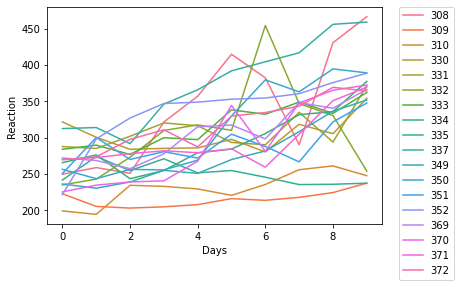

In [38]:
## Plotting curve of 18 subjects
_ = sns.lineplot(x="Days", y="Reaction", hue="Subject", data=sleepstudy)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

In [39]:
# Design Matrix
X = dmatrix("~ Days", sleepstudy, return_type="dataframe")

# Z specification
Z = [mc_id(sleepstudy)] + mc_mixed(formula="~ 0 + Subject / Days", data=sleepstudy)

In [40]:
# Model fitting
mcglm = MCGLM(endog=sleepstudy["Reaction"], exog=X, z=Z)

mcglmresults = mcglm.fit()

In [41]:
mcglmresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:               Reaction   No. Iterations:                     20
Model:                          MCGLM   No. Observations:                  180
link:                        identity   Df Residuals:                      174
variance:                    constant   Df Model:                            6
Method:              Quasi-Likelihood   Power-fixed:                      True
Date:                Thu, 08 Sep 2022   pAIC                           1583.94
Time:                        20:54:09   pBIC                            1603.1
                                        pLogLik                      -785.9704
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    251.4051      6.632     37.906      0.000     238.406     264.404
Days          10.4673      1.502      6.968      0.000       7.523      13.412
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1   654.9420     70.624      9.274      0.000     516.521     793.363
dispersion_2   565.5150    264.679      2.137      0.033      46.753    1084.277
dispersion_3    32.6820     13.560      2.410      0.016       6.105      59.259
dispersion_4    11.0550     42.948      0.257      0.797     -73.121      95.231
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         1.0000        nan        nan        nan         nan         nan
==============================================================================
"""

#### Beta coefficients  
The Beta section diagnose the fixed-effects parameters, that is to say, the conclusion overall subjects.  

    Intercept set at value 251.40. The straightforward takeaway is: At day 0, the average response time is roughly 251 seconds.
    In addition, Days at 10.46 allude to total change to response time by unit changes on Days, for subjects with random effects set to 0.
    Furthermore, by the results of the wald test on Days, we might conclude that days are statistically significant in the statistical model.
---
#### Dispersion parameters   
The Dispersion parameters allude to random effects within individuals throughout the days.  

    The first dispersion parameter is the variance across all data points. Calculated in 654.94.
    The second dispersion parameter is the variance across all intercepts, which is 565.51.
    The third dispersion parameter is the variance across all slopes. Calculated in 32.68. 
    The fourth dispersion parameter is the variance across intercepts and slopes. Calculated in 11.05.

* Moreover, the correlation might be calculated through the formula = dispersion_4/(sqrt(dispersion_2) + sqrt(dispersion_3)). Cell below shows the pearson correlation result, 0.37.   

##### Multivariate Models
-------------

Soya

`Soya` is a dataset that stores an experiment of Universidade Federal da Grande Dourados in Dourados, Mato Grosso do Sul, Brazil. Description:    
https://github.com/walmes/wzRfun/blob/master/R/wzRfun.R#L10   
http://ccarevista.ufc.br/seer/index.php/ccarevista/article/view/1454  

The experiment collected data about different treatments of `potassium`, `water`, and `blocks` for soil farming on buckets. All of those covariates are categorical. The response traits to be analyzed are: `grain size`, `total seeds`, and `viable peas`, which stands for the weight of hundred grains, total grain per bucket, and percentage of viable peas(green beans). In the following, MCGLM fits onto this data with three unique kinds of answers: continuous, count, and binomial.

In [31]:
soya = pd.read_csv(
    "data/fourth_simulation/soya.csv",
    dtype={"block": "str", "water": "str", "pot": "str"},
)

soya["viablegrain"] = soya["viablepeas"] / soya["totalpeas"]

In [32]:
# percentual of peas.
soya["viablePeas"] = soya["viablepeas"] / soya["totalpeas"]

# Design matrix.
X = dmatrix("~ block + water * pot", soya, return_type="dataframe")

In [33]:
# Model Specification
mcglm = MCGLM(
    endog=[soya["grain"], soya["seeds"], soya["viablePeas"]],
    exog=[X, X, X],
    z=[[mc_id(soya)], [mc_id(soya)], [mc_id(soya)]],
    link=["identity", "log", "logit"],
    variance=["constant", "tweedie", "binomialP"],
    ntrial=[None, None, soya["totalpeas"].values],
)


mcglmresults = mcglm.fit()

In [34]:
mcglmresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:                  grain   No. Iterations:                      3
Model:                          MCGLM   No. Observations:                   75
link:                        identity   Df Residuals:                       55
variance:                    constant   Df Model:                           20
Method:              Quasi-Likelihood   Power-fixed:                      True
Date:                Sun, 27 Nov 2022   pAIC                            448.02
Time:                        19:24:26   pBIC                            516.34
                                        pLogLik                      -204.0085
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   14.2455      1.217     11.701      0.000      11.859      16.632
block[T.II]                  1.1326      0.880      1.287      0.198      -0.593       2.858
block[T.III]                -0.7797      0.880     -0.886      0.376      -2.505       0.946
block[T.IV]                 -1.5495      0.880     -1.760      0.078      -3.275       0.176
block[T.V]                  -2.3866      0.880     -2.711      0.007      -4.112      -0.661
water[T.50]                  2.1660      1.531      1.415      0.157      -0.834       5.166
water[T.62.5]                2.5404      1.531      1.660      0.097      -0.460       5.541
pot[T.120]                  11.7898      1.531      7.702      0.000       8.790      14.790
pot[T.180]                  11.8633      1.531      7.750      0.000       8.863      14.864
pot[T.30]                    6.7894      1.531      4.435      0.000       3.789       9.790
pot[T.60]                   10.3978      1.531      6.793      0.000       7.398      13.398
water[T.50]:pot[T.120]       2.2541      2.165      1.041      0.298      -1.989       6.497
water[T.62.5]:pot[T.120]     5.5826      2.165      2.579      0.010       1.340       9.826
water[T.50]:pot[T.180]       1.2097      2.165      0.559      0.576      -3.033       5.453
water[T.62.5]:pot[T.180]     9.2391      2.165      4.268      0.000       4.996      13.482
water[T.50]:pot[T.30]        0.1069      2.165      0.049      0.961      -4.136       4.350
water[T.62.5]:pot[T.30]     -1.8677      2.165     -0.863      0.388      -6.111       2.375
water[T.50]:pot[T.60]        2.6035      2.165      1.203      0.229      -1.640       6.847
water[T.62.5]:pot[T.60]      3.3585      2.165      1.551      0.121      -0.885       7.602
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1     5.8610      1.671      3.507      0.000       2.586       9.136
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         1.0000        nan        nan        nan         nan         nan
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:                  seeds   No. Iterations:                      3
Model:                          MCGLM   No. Observations:                   75
link:                             log   Df Residuals:                       55
variance:                     tweedie   Df Model:                           20
Me

The three responses have generated a three-section report. As it follows, a analysis per response.

---
`grain` size.

The grain response was fitted with default parameters, `identity` and `constant`, generating a near homoscedastic linear model. Among covariates `block`, `water` and `potassium`, by Wald test, potassium levels are statistically significant for the model; the higher potassium level, bigger grain size. Variance constant on 5.862.   

Residual analysis:

Text(0, 0.5, 'pearson residual')

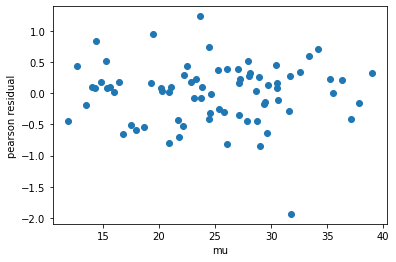

In [35]:
# grain. residual analysis
plt.scatter(mcglmresults.mu[0], mcglmresults.pearson_residuals[0])
plt.xlabel("mu")
plt.ylabel("pearson residual")

Despite the outlier, the fit seems pretty good.

---
`seed` count.

As long as seed is a count variable, a straightforward and canonical way to model it is Poisson. Two out of three covariates are statistically significant on `seed`: potassium, for every level; and black for level V.

Residual analysis:

Text(0, 0.5, 'pearson residual')

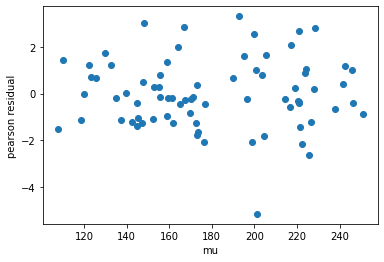

In [36]:
# seeds. residual analysis
plt.scatter(mcglmresults.mu[1], mcglmresults.pearson_residuals[1])
plt.xlabel("mu")
plt.ylabel("pearson residual")

Notwithstanding the outlier, the fit is good.

---
Percentage of `viable peas`.

Binomial N trials is the adequate model for bounded data. Perhaps, the most popular solution to fit is the `Logit` link, the one used. Among covariates, only potassium level 30, and water level 50 are statistically significant with Viable Peas.

Residual Analysis:

Text(0, 0.5, 'pearson residual')

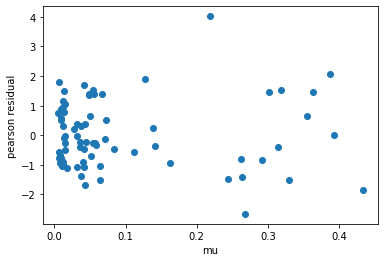

In [37]:
# viablepeasP. residual analysis
plt.scatter(mcglmresults.mu[2], mcglmresults.pearson_residuals[2])
plt.xlabel("mu")
plt.ylabel("pearson residual")

The model has not fitted well. It is possible to try out different values for link and variance functions. Suppose it does not improve the model fit. In that case, it will let us conclude a non-assessment for the percentage of viable peas from current covariates.   

The last three components rhos allude to the correlation coefficient among responses. 
 * rho_1 stands for grain size and whole seeds, with a considerable Pearson correlation of 0.63.
 * rho_2 and rho_3 stand for correlation between grain size and viable peas, seed count, and viable peas, respectively. Both correlations are low. 